In [19]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import imageio
import cv2 as cv
from IPython.display import Image
from IPython.display import Video
import os

N = 512

def Bilinear(tex, x, y):
    xi, yi = tf.floor(x), tf.floor(y)
    xf, yf = x-xi, y-yi
    xi, yi = tf.int(xi), tf.int(yi)
    oxf, oyf = 1.0-xf, 1.0-yf
    return tex[xi, yi]*oxf*oyf + tex[xi+1, yi]*xf*oyf + tex[xi, yi+1]*oxf*yf + tex[xi+1, yi+1]*xf*yf

def CubicHermit(x):
    x2 = x * x
    x3 = x2 * x
    return [-0.5 * x3 + x2 - 0.5 * x, 1.5 * x3 - 2.5 * x2 + 1.0, -1.5 * x3 + 2.0 * x2 + 0.5 * x, 0.5 * x3 - 0.5 * x2]

def CubicInterp(tex, x, y):
    xi, yi = tf.floor(x), tf.floor(y)
    xf, yf = x-xi, y-yi
    xi, yi = tf.int(xi), tf.int(yi)

    wx = CubicHermit(xf)
    wy = CubicHermit(yf)

    valueY = 0
    for j in range(-1, 3):
        valueX = 0
        for i in range(-1, 3):
            valueX = valueX + tex[xi + i, yi + j] * wx[i + 1]
        valueY = valueY + valueX * wy[j + 1]
    return valueY

def EulerAdvection(vx, vy, dt):
    i,j = vx.indices
    x, y = tf.float(i), tf.float(j)
    x1, y1 = x - vx*dt, y - vy*dt
    return x1, y1

def RK4Advection(vx, vy, dt):
    i, j = vx.indices
    x, y = tf.float(i), tf.float(j)

    x1, y1 = x - vx*dt/2.0, y - vy*dt/2.0
    vx1, vy1 = Bilinear(vx, x1, y1), Bilinear(vy, x1, y1)

    x2, y2 = x - vx1*dt/2.0, y - vy1*dt/2.0
    vx2, vy2 = Bilinear(vx, x2, y2), Bilinear(vy, x2, y2)

    x3, y3 = x - vx2*dt, y - vy2*dt
    vx3, vy3 = Bilinear(vx, x3, y3), Bilinear(vy, x3, y3)

    x4, y4 = x - (vx + 2.0*vx1 + 2.0*vx2 + vx3)*dt/6.0, y - (vy + 2.0*vy1 + 2.0*vy2 + vy3)*dt/6.0
    return x4, y4

def SemiLagrange(vx, vy, density, dt):
    # advect velocity
    x1, y1 = RK4Advection(vx, vy, dt)

    vx = CubicInterp(vx, x1, y1)
    vy = CubicInterp(vy, x1, y1)
    density = CubicInterp(density, x1, y1)

    return [vx, vy, density]

def BFECC(vx, vy, density, dt):
    i, j = vx.indices
    x, y = tf.float(i), tf.float(j)

    # advect velocity
    x1, y1 = EulerAdvection(vx, vy, dt)
    vx1, vy1, density1 = Bilinear(vx, x1, y1), Bilinear(vy, x1, y1), Bilinear(density, x1, y1)

    # advect backwards
    x2, y2 = EulerAdvection(vx1, vy1, -dt)
    vx2, vy2, density2 = Bilinear(vx, x2, y2), Bilinear(vy, x2, y2), Bilinear(density, x2, y2)

    # compute forward error correction
    vx = vx1 + (vx1 - vx2)*0.12
    vy = vy1 + (vy1 - vy2)*0.12
    density = density1 + (density1 - density2)*0.12

    return [vx, vy, density]

def FluidTest():
    vx = tf.input([N, N], tf.float32)
    vy = tf.input([N, N], tf.float32)
    density = tf.input([N, N], tf.float32)
    pressure = tf.input([N, N], tf.float32)

    dt = 1.0
    i,j = vx.indices
    x, y = tf.float(i), tf.float(j)

    vx, vy, density = SemiLagrange(vx, vy, density, dt)
    
    # add source
    source = 0.042*tf.exp(-((x-N/5.0)**2.0 + (y-2.0*N/3.0)**2.0)/100.0)
    source = source + 0.04*tf.exp(-((x-N/5.0)**2.0 + (y-N/3.0)**2.0)/100.0)
    density = density + source
    vx = vx + source

    edge = 1.0 - tf.float((i < 2) | (i > N-3) | (j < 2) | (j > N-3))
    vx = vx * edge
    vy = vy * edge
    density = density * edge

    # compute divergence
    div = (vx[i+1, j] - vx[i-1, j] + vy[i, j+1] - vy[i, j-1]) / 2.0

    # pressure solve
    for it in range(2):
        pressure = (pressure[i-1, j] + pressure[i+1, j] + pressure[i, j-1] + pressure[i, j+1] - div) / 4.0
    
    # subtract pressure gradient
    gradx = (pressure[i+1, j] - pressure[i-1, j])*1.0
    grady = (pressure[i, j+1] - pressure[i, j-1])*1.0
    vx = vx - gradx
    vy = vy - grady

    return [vx, vy, density, pressure]

tf.initialize(tf.cpu, "H:/cl_compile.bat /O2 /fp:fast /openmp:experimental")
fluid = tf.program(FluidTest)



dim =  2
dim =  2


In [20]:
VX = tf.memory(np.zeros((N, N)))
VY = tf.memory(np.zeros((N, N)))
DENSITY = tf.memory(np.zeros((N, N)))
PRESSURE = tf.memory(np.zeros((N, N)))

#do a few steps and measure performance by timing every 100 steps
start = time.time()

file_path = 'H:/TestVideos/fluid.gif'
writer = imageio.get_writer(file_path, fps=30)

#use opencv to write is as video too
video_path = 'H:/TestVideos/fluid.mp4'
fourcc = cv.VideoWriter_fourcc(*'H264')
video = cv.VideoWriter(video_path, fourcc, 30, (N, N))

for i in range(1000):
    VX, VY, DENSITY, PRESSURE = fluid(VX, VY, DENSITY, PRESSURE)

    if i % 10 == 0:
        color = (np.clip(DENSITY.numpy, 0.0, 1.0)*255.0).astype(np.uint8)
        color_rgb = cv.cvtColor(color, cv.COLOR_GRAY2RGB)
        writer.append_data(color)
        video.write(color_rgb)

    if i % 100 == 99:
        print("Iterations per second: " + str(100/(time.time()-start)))
        start = time.time()

writer.close()
video.release()

Iterations per second: 121.65449726456747
Iterations per second: 139.47010521681474
Iterations per second: 165.56301951796786
Iterations per second: 199.2035286010172
Iterations per second: 193.05023498963706
Iterations per second: 203.66611278419657
Iterations per second: 203.666013888491
Iterations per second: 200.80305826648762
Iterations per second: 204.9182682583405
Iterations per second: 201.6129792047007


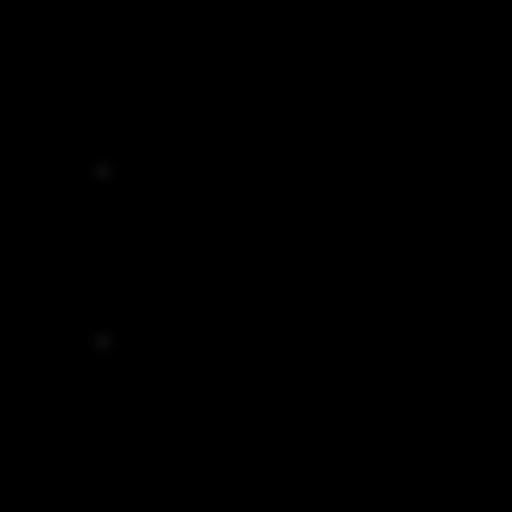

In [21]:
Image(file_path)

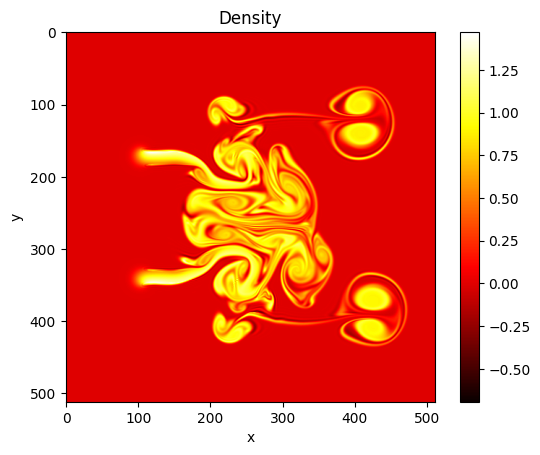

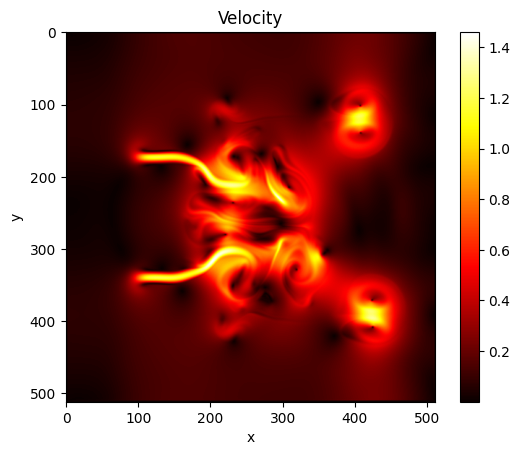

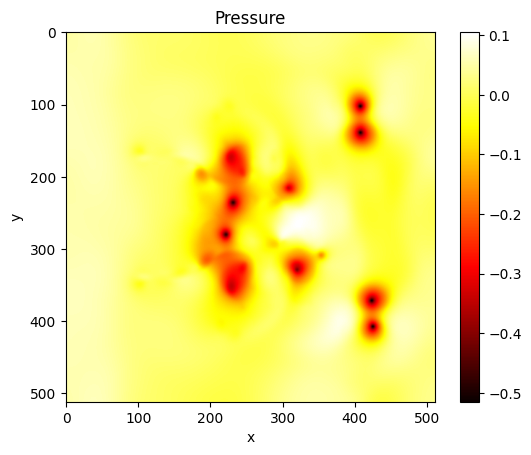

In [22]:
# plot the final density with colorbar
plt.imshow(DENSITY.numpy, cmap='hot')
plt.colorbar()
plt.title('Density')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# plot the final velocity with colorbar
plt.imshow(np.sqrt(VX.numpy**2.0 + VY.numpy**2.0), cmap='hot')
plt.colorbar()
plt.title('Velocity')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# plot the final pressure with colorbar
plt.imshow(PRESSURE.numpy, cmap='hot')
plt.colorbar()
plt.title('Pressure')
plt.xlabel('x')
plt.ylabel('y')
plt.show()